In [220]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [221]:
#read coronavirus cases by zip data from:
#https://github.com/nychealth/coronavirus-data/trends/caserate-by-modzcta.csv

cases_by_zip = pd.read_csv(r'C:\Users\peter\metis\caserate-by-modzcta.csv')
cases_by_zip.head()

,week_ending,CASERATE_CITY,CASERATE_BX,CASERATE_BK,CASERATE_MN,CASERATE_QN,CASERATE_SI,CASERATE_10001,CASERATE_10002,CASERATE_10003,...,CASERATE_11432,CASERATE_11433,CASERATE_11434,CASERATE_11435,CASERATE_11436,CASERATE_11691,CASERATE_11692,CASERATE_11693,CASERATE_11694,CASERATE_11697
0,9/26/2020,40.84,32.72,58.48,31.31,32.08,44.31,10.86,25.22,59.28,...,51.02,30.12,19.47,27.39,24.95,107.69,19.02,7.89,24.06,0.00
1,10/3/2020,48.80,32.36,69.92,34.51,44.72,52.30,36.21,19.91,57.43,...,77.36,41.07,16.48,56.49,29.94,172.01,23.78,47.35,43.31,0.00
2,10/10/2020,48.58,38.15,65.55,31.68,46.14,57.76,39.84,35.85,29.64,...,70.78,35.60,25.46,66.76,29.94,121.16,52.31,7.89,24.06,0.00
3,10/17/2020,49.06,44.21,58.05,40.34,45.52,61.75,32.59,30.54,70.40,...,41.15,24.64,16.48,49.64,34.93,59.83,28.53,23.67,28.87,29.48
4,10/24/2020,60.06,53.80,65.20,48.50,60.92,86.53,50.70,50.45,53.73,...,49.38,43.81,20.97,59.92,54.88,52.35,23.78,71.02,43.31,88.43


In [222]:
#read station/zip code mapping from:
#https://github.com/galenballew/Metis-Submissions/projects/01 Benson/data/processed/zips.csv
#note: ZIPS must be read as strings so as to not lose the leading zero eg in 07102
station_zips = pd.read_csv(r'C:\Users\peter\metis\station_zips.csv', dtype={'ZIP': 'str'})
station_zips.head()

,STATION,ZIP
0,59 ST,10065
1,5 AV/59 ST,10019
2,57 ST-7 AV,10106
3,49 ST,10020
4,TIMES SQ-42 ST,10018


In [223]:
#read in turnstile data from:
#http://web.mta.info/developers/turnstile.html
#we will start with initial and final values of entries and exits for the period of inquiry

week_200926 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_200926_weekly_use.csv')
week_210529 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210529_weekly_use.csv')

#week_200926.info()
#week_210529.info()
#note to self: 200926 has 751 rows, whereas 210539 has 750
#this disparity will be eliminated when we merge turnstiles with zip codes

display(week_200926.head())
display(week_210529.head())

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/26/2020,00:00:00,REGULAR,7463495,2538694
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,09/26/2020,02:00:00,REGULAR,4337234,7476733
2,A007,R079,01-05-00,5 AV/59 ST,NQRW,BMT,09/26/2020,02:00:00,REGULAR,3606,0
3,A010,R080,00-00-00,57 ST-7 AV,NQRW,BMT,09/26/2020,00:00:00,REGULAR,5008231,2849925
4,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,09/26/2020,00:00:00,REGULAR,465980,1599084


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,05/29/2021,02:00:00,REGULAR,4464941,7686813
2,A007,R079,01-05-00,5 AV/59 ST,NQRW,BMT,05/29/2021,02:00:00,REGULAR,3672,0
3,A010,R080,00-00-00,57 ST-7 AV,NQRW,BMT,05/29/2021,00:00:00,REGULAR,5135598,3043226
4,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,05/29/2021,00:00:00,REGULAR,491133,1626443


In [224]:
#merge turnstile data with zip code for each week
turnstiles_200926_zip = pd.merge(week_200926, station_zips, how='inner', on = "STATION")
turnstiles_210529_zip = pd.merge(week_210529, station_zips, how='inner', on = "STATION")

#note to self: 200926 has 731 rows whereas 210529 has 730
#this disparity will be eliminated when we group by zip

display(turnstiles_200926_zip.head())
display(turnstiles_210529_zip.head())

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ZIP
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/26/2020,00:00:00,REGULAR,7463495,2538694,10065
1,C021,R212,00-00-00,59 ST,NRW,BMT,09/26/2020,00:00:00,REGULAR,9349965,4860529,10065
2,C022,R212,01-00-00,59 ST,NRW,BMT,09/26/2020,00:00:00,REGULAR,590467,594813,10065
3,R244,R050,00-00-00,59 ST,456NQRW,IRT,09/26/2020,00:00:00,REGULAR,763398,1836773,10065
4,R244A,R050,01-00-00,59 ST,456NQRW,IRT,09/26/2020,00:00:00,REGULAR,4922318,19716471,10065


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ZIP
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/29/2021,00:00:00,REGULAR,7578734,2590325,10065
1,C021,R212,00-00-00,59 ST,NRW,BMT,05/29/2021,00:00:00,REGULAR,9523189,4967775,10065
2,C022,R212,01-00-00,59 ST,NRW,BMT,05/29/2021,00:00:00,REGULAR,704908,749631,10065
3,R244,R050,00-00-00,59 ST,456NQRW,IRT,05/29/2021,00:00:00,REGULAR,873257,2088845,10065
4,R244A,R050,01-00-00,59 ST,456NQRW,IRT,05/29/2021,00:00:00,REGULAR,4934310,20001952,10065


In [225]:
#aggregate transit byzip for each week,summing entries and exits for entries within the same zip code
#for starters we're just looking at time_initial and time_final
ti_zip_entries_and_exits  = turnstiles_200926_zip.groupby("ZIP").agg({"ENTRIES" : "sum", "EXITS" : "sum"})
tf_zip_entries_and_exits = turnstiles_210529_zip.groupby("ZIP").agg({"ENTRIES" : "sum", "EXITS" : "sum"})

#time_initial
ti = ti_zip_entries_and_exits
#time_final
tf = tf_zip_entries_and_exits
#time_difference between final and initial
tdiff = tf- ti

#eliminate rows with negatives
(tdiff > 0).all(1)
tdiff = tdiff[(tdiff > 0).all(1)]

#add column for average
tdiff["AVERAGE"] = (tdiff["ENTRIES"] + tdiff["EXITS"])/2

#add column for entries-exits difference
tdiff["NET_ENTRIES"] = tdiff["ENTRIES"] - tdiff["EXITS"]

#add column for percent difference
tdiff["PERCENT_DIFFERENCE"] = tdiff["NET_ENTRIES"]/tdiff["AVERAGE"]

tdiff = tdiff.sort_values("PERCENT_DIFFERENCE")

display(tdiff)

,ENTRIES,EXITS,AVERAGE,NET_ENTRIES,PERCENT_DIFFERENCE
ZIP,,,,,
10533,22606,336045,179325.5,-313439,-1.747877
11235,55538,684949,370243.5,-629411,-1.699992
10033,74525,484520,279522.5,-409995,-1.466769
10012,406700,1742849,1074774.5,-1336149,-1.243190
10013,350896,1484064,917480.0,-1133168,-1.235087
...,...,...,...,...,...
11223,128311,25391,76851.0,102920,1.339215
11414,108703,20953,64828.0,87750,1.353582
10463,296711,17588,157149.5,279123,1.776162


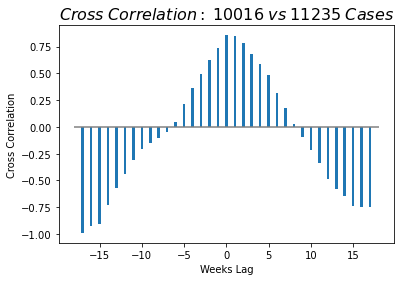

In [244]:
#consider covid time series cross correlations 
#serial cross correlations between covid cases of example source vs sink

#sink example: high exits
time_series_11235 = cases_by_zip["CASERATE_11235"]

#source example: high entries
time_series_10016 = cases_by_zip["CASERATE_10016"]

#computes cross correaltions for weekly lags [ie frameshifts] -18 to -1
#fullback = sm.tsa.stattools.ccf(time_series_10016, time_series_11235)[:0:-1]
back = sm.tsa.stattools.ccf(time_series_10016, time_series_11235)[17:0:-1]

#print(len(back), len(fullback))
#len(back) = 17; len(fullback) = 35


#computes cross correlations for weekly lags 0 to 17
#fullfore = sm.tsa.stattools.ccf(time_series_11235, time_series_10016)
fore = sm.tsa.stattools.ccf(time_series_11235, time_series_10016)[0:18:1]

#print(len(fore), len(fullfore))
#len(fore) = 18; len(fullfore) = 36

#NOTE: no lag correlation = 0.85535

#two sided array of cross correalations for -17 to + 17 lag
two_sided = np.concatenate((back, fore), axis=0)
lags = list(range(-17,18))
#print(len(lags), len(two_sided))
#both length 35

#two_sided
plt.hlines(0, xmin=-18, xmax=18, color='gray')
plt.bar(lags, two_sided, width=.3)
plt.title('$Cross\; Correlation:\; 10016 \; vs\; 11235\; Cases$', fontsize=16)
plt.xlabel("Weeks Lag")
plt.ylabel("Cross Correlation");
plt.savefig("ccf.png")

In [246]:
#mean weeks of epidemic
#a few examples
weeks = list(range(1, 37))

#sink example
mean_week_11235 = np.dot(weeks, cases_by_zip["CASERATE_11235"])/cases_by_zip["CASERATE_11235"].sum()
#19.27

#source example
mean_week_10016 = np.dot(weeks, cases_by_zip["CASERATE_10016"])/cases_by_zip["CASERATE_10016"].sum()
#18.544


In [247]:
#function calculates mean week of epidemic
def mean_week (zip):
    weeks = list(range(1,37))
    return np.dot(weeks,zip)/zip.sum()

#create a list of ZIP codes, from case rate zips
#cleans up location heading from coronavirus data, in order, for compatablitiy with turnstile ZIPs *Consider type differences
zips = cases_by_zip.columns.str.replace("CASERATE_", "")
#zips = zips.values
zips = zips.values.tolist()
#get rid of first element, week_ending
del zips[0]


#calls mean_week calculating function to reate a list of mean weeks by ZIP
mean_weeks = []
for col_name in cases_by_zip.columns: 
    if col_name == "week_ending": pass
    else:
        mean_weeks.append(mean_week(cases_by_zip[col_name]))
        
#turn lists into df
mean_weeks_by_zip = pd.DataFrame(zips, mean_weeks)

#data cleaning -adjust index and column names
mean_weeks_by_zip.reset_index(level=0, inplace=True)
mean_weeks_by_zip.rename(columns = {'index': 'MEAN_WEEK', 0: 'ZIP'}, inplace = True)
mean_weeks_by_zip

#mean_weeks_by_zip merge through zip with entries data
mean_weeks_entries_by_zip = pd.merge(mean_weeks_by_zip, tdiff, how='inner', on = "ZIP")
mean_weeks_entries_by_zip

,MEAN_WEEK,ZIP,ENTRIES,EXITS,AVERAGE,NET_ENTRIES,PERCENT_DIFFERENCE
0,19.503116,10001,792669,1204597,998633.0,-411928,-0.412492
1,17.444796,10004,408758,530260,469509.0,-121502,-0.258785
2,18.814286,10006,132779,75777,104278.0,57002,0.546635
3,18.909489,10010,1136153,1540071,1338112.0,-403918,-0.301857
4,18.678334,10011,536834,800480,668657.0,-263646,-0.394292
...,...,...,...,...,...,...,...
90,19.029573,11435,361080,263747,312413.5,97333,0.311552
91,18.715057,11691,163685,352539,258112.0,-188854,-0.731675
92,19.814593,11692,151467,178142,164804.5,-26675,-0.161858
93,18.963184,11693,35337,31653,33495.0,3684,0.109987


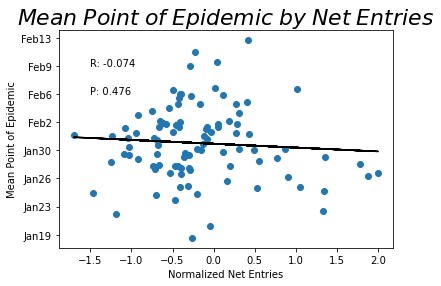

In [248]:
#scatter
#we might expect zip codes with positive net entries (sources) to have earlier otbreaks than sink zip codes with higher exits
x = mean_weeks_entries_by_zip.PERCENT_DIFFERENCE
y = mean_weeks_entries_by_zip.MEAN_WEEK
#m, b = np.polyfit(x,y, 1)
slope, intercept, r_value, p_value, std_err = ss.linregress(x, y)

plt.scatter(x, y)
plt.plot(x, slope*x + intercept, color ="k")
plt.title('$Mean\; Point\; of\; Epidemic\; by \; Net\; Entries$', fontsize=22)
plt.xlabel("Normalized Net Entries")
plt.ylabel("Mean Point of Epidemic")
plt.yticks([17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21], ['Jan19', 'Jan23', 'Jan26', 'Jan30', 'Feb2', 'Feb6', 'Feb9', 'Feb13' ])
plt.text(-1.5, 20.5, "R: -0.074")
plt.text(-1.5, 20, "P: 0.476");
plt.savefig("mean_point_by_entries.png")

In [249]:
#consider mean weeks of epidemic compare 

#next step: use longitude and latitude accompanying the MTA turnstile data for comarrison with mean weeks
#ie two separate graphs consider showing both later

#average long and lat for stations in zip

#read in turnstile data from:
#http://web.mta.info/developers/turnstile.html
#we will start with initial and final values of entries and exits for the period of inquiry

long_and_lat = pd.read_csv(r'C:\Users\peter\metis\stations_with_long_and_lat.csv')
long_and_lat['Stop Name'] = long_and_lat['Stop Name'].str.upper()
long_and_lat.rename(columns = {'Stop Name': 'STATION'}, inplace = True)
long_and_lat

long_and_lat_zip = pd.merge(long_and_lat, station_zips, how='inner', on = "STATION")
long_and_lat_zip
long_and_lat_zip  = long_and_lat_zip.groupby("ZIP").agg({"GTFS Latitude" : "mean", "GTFS Longitude" : "mean"})
long_and_lat_zip
#avg long and lats by zip
mean_weeks_entries_by_long_and_lat = pd.merge(mean_weeks_by_zip, long_and_lat_zip, how='inner', on = "ZIP")
mean_weeks_entries_by_long_and_lat

,MEAN_WEEK,ZIP,GTFS Latitude,GTFS Longitude
0,19.503116,10001,40.745465,-73.987099
1,19.464460,10002,40.716047,-73.979628
2,19.367725,10003,40.731174,-73.990046
3,17.444796,10004,40.703442,-74.013865
4,19.563684,10005,40.706951,-74.010673
...,...,...,...,...
99,19.029573,11435,40.707319,-73.815641
100,18.715057,11691,40.596136,-73.768514
101,19.814593,11692,40.591651,-73.792723
102,18.963184,11693,40.598208,-73.814783


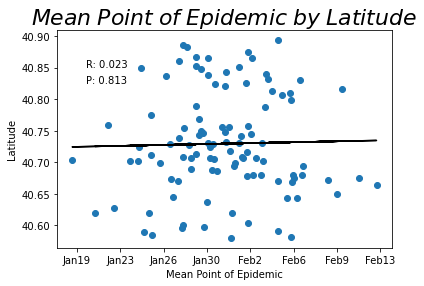

In [250]:
#scatter
#we expect negative percent difference to occur later
y = mean_weeks_entries_by_long_and_lat["GTFS Latitude"]
x = mean_weeks_entries_by_long_and_lat.MEAN_WEEK
#m, b = np.polyfit(x,y, 1)
slope, intercept, r_value, p_value, std_err = ss.linregress(x, y)

plt.scatter(x, y)
plt.plot(x, slope*x + intercept, color ="k")
plt.title('$Mean\; Point\; of\; Epidemic\; by \; Latitude$', fontsize=22)
plt.xlabel("Mean Point of Epidemic")
plt.xticks([17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21], ['Jan19', 'Jan23', 'Jan26', 'Jan30', 'Feb2', 'Feb6', 'Feb9', 'Feb13' ])
plt.ylabel("Latitude")
plt.text(17.6, 40.85, "R: 0.023")
plt.text(17.6, 40.825, "P: 0.813");
plt.savefig("mean_point_latitude.png")

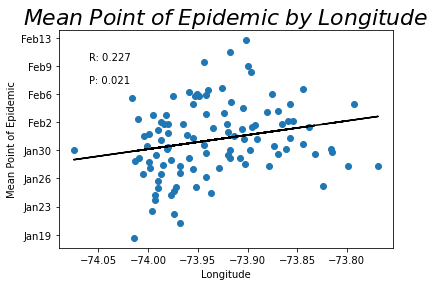

In [251]:
#scatter
#we want negative percent difference to occur later
x = mean_weeks_entries_by_long_and_lat["GTFS Longitude"]
y = mean_weeks_entries_by_long_and_lat.MEAN_WEEK
#m, b = np.polyfit(x,y, 1)
slope, intercept, r_value, p_value, std_err = ss.linregress(x, y)

plt.scatter(x, y)
plt.plot(x, slope*x + intercept, color ="k")
plt.title('$Mean\; Point\; of\; Epidemic\; by \; Longitude$', fontsize=22)
plt.xlabel("Longitude")
plt.ylabel("Mean Point of Epidemic")
plt.yticks([17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21], ['Jan19', 'Jan23', 'Jan26', 'Jan30', 'Feb2', 'Feb6', 'Feb9', 'Feb13' ])
plt.text(-74.06, 20.6, "R: 0.227")
plt.text(-74.06, 20.2, "P: 0.021");
plt.savefig("mean_point_longitude.png")

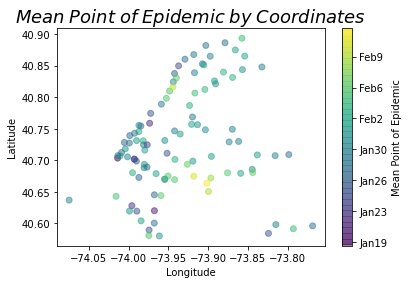

In [267]:
#heat/scatter
#longitude on x axis, latitude on y, color encodes mean week
x = mean_weeks_entries_by_long_and_lat["GTFS Longitude"]
y = mean_weeks_entries_by_long_and_lat["GTFS Latitude"]
plt.scatter(x, y, c=mean_weeks_entries_by_long_and_lat.MEAN_WEEK, alpha=0.5,
cmap='viridis')
plt.title('$Mean\; Point\; of\; Epidemic\; by \; Coordinates$', fontsize=18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar(ticks=[17.5, 18, 18.5, 19, 19.5, 20, 20.5, 21]) 
cbar.ax.set_yticklabels(['Jan19', 'Jan23', 'Jan26', 'Jan30', 'Feb2', 'Feb6', 'Feb9', 'Feb13' ])
cbar.set_label('Mean Point of Epidemic')
plt.savefig("mean_point_coordinates.png")

,MEAN_WEEK,ZIP
0,19.224646,CITY
1,19.319143,BX
2,19.331292,BK
3,19.009383,MN
4,19.356153,QN
5,18.565621,SI


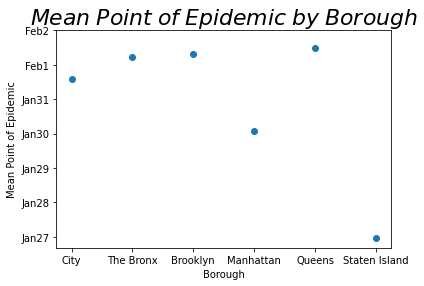

In [253]:
#aim is to clean up coronavirus time series by zip code with long and lat coordinates
cases_by_zip = pd.read_csv(r'C:\Users\peter\metis\caserate-by-modzcta.csv')
cases_by_zip.head()
#clean up the heading by transforming column names
zips = cases_by_zip.columns.str.replace("CASERATE_", "")

#reestablish cases_by_zip with new heading
cases_by_zip.columns = zips

mean_weeks_by_borough = mean_weeks_by_zip.iloc[0:6,]
display(mean_weeks_by_borough)


x = mean_weeks_by_borough.ZIP
y = mean_weeks_by_borough.MEAN_WEEK
plt.scatter(x, y)
plt.title('$Mean\; Point\; of\; Epidemic\; by \; Borough$', fontsize=22)
plt.ylabel("Mean Point of Epidemic")
plt.yticks([18.5714 , 18.71428, 18.8571, 19, 19.1428, 19.2857, 19.4286 ], ['Jan27', 'Jan28', 'Jan29', 'Jan30', 'Jan31', 'Feb1', 'Feb2' ])
plt.xlabel("Borough")
plt.xticks([0, 1, 2, 3, 4, 5],['City', 'The Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']);
plt.savefig("mean_point_borough.png")

In [255]:
week_200926 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_200926_weekly_use.csv')
week_201003 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201003_weekly_use.csv')
week_201010 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201010_weekly_use.csv')
week_201017 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201017_weekly_use.csv')
week_201024 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201024_weekly_use.csv')
week_201031 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201031_weekly_use.csv')
week_201107 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201107_weekly_use.csv')
week_201114 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201114_weekly_use.csv')
week_201121 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201121_weekly_use.csv')
week_201128 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201128_weekly_use.csv')
week_201205 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201205_weekly_use.csv')
week_201212 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201212_weekly_use.csv')
week_201219 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201219_weekly_use.csv')
week_201226 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_201226_weekly_use.csv')
week_210102 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210102_weekly_use.csv')
week_210109 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210109_weekly_use.csv')
week_210116 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210116_weekly_use.csv')
week_210123 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210123_weekly_use.csv')
week_210130 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210130_weekly_use.csv')
week_210206 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210206_weekly_use.csv')
week_210213 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210213_weekly_use.csv')
week_210220 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210220_weekly_use.csv')
week_210227 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210227_weekly_use.csv')
week_210306 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210306_weekly_use.csv')
week_210313 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210313_weekly_use.csv')
week_210320 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210320_weekly_use.csv')
week_210327 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210327_weekly_use.csv')
week_210403 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210403_weekly_use.csv')
week_210410 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210410_weekly_use.csv')
week_210417 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210417_weekly_use.csv')
week_210424 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210424_weekly_use.csv')
week_210501 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210501_weekly_use.csv')
week_210508 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210508_weekly_use.csv')
week_210515 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210515_weekly_use.csv')
week_210522 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210522_weekly_use.csv')
week_210529 = pd.read_csv(r'C:\Users\peter\metis\turnstile_data_for_MTA_project\transformed\turnstile_210529_weekly_use.csv')

def process_weekly_turnstiles(week):
    return(pd.merge(week, station_zips, how='inner', on = "STATION").groupby("ZIP").agg({"ENTRIES" : "sum", "EXITS" : "sum"}))

entries_200926 = process_weekly_turnstiles(week_200926).iloc[:,:-1] #entries with zip for week
entries_201003 = process_weekly_turnstiles(week_201003).iloc[:,:-1]
entries_201010 = process_weekly_turnstiles(week_201010).iloc[:,:-1] 
entries_201017 = process_weekly_turnstiles(week_201017).iloc[:,:-1] 
entries_201024 = process_weekly_turnstiles(week_201024).iloc[:,:-1] 
entries_201031 = process_weekly_turnstiles(week_201031).iloc[:,:-1] 
entries_201107 = process_weekly_turnstiles(week_201107).iloc[:,:-1]
entries_201114 = process_weekly_turnstiles(week_201114).iloc[:,:-1] 
entries_201121 = process_weekly_turnstiles(week_201121).iloc[:,:-1]
entries_201128 = process_weekly_turnstiles(week_201128).iloc[:,:-1]
entries_201205 = process_weekly_turnstiles(week_201205).iloc[:,:-1]
entries_201212 = process_weekly_turnstiles(week_201212).iloc[:,:-1]
entries_201219 = process_weekly_turnstiles(week_201219).iloc[:,:-1]
entries_201226 = process_weekly_turnstiles(week_201226).iloc[:,:-1]
entries_210102 = process_weekly_turnstiles(week_210102).iloc[:,:-1]
entries_210109 = process_weekly_turnstiles(week_210109).iloc[:,:-1]
entries_210116 = process_weekly_turnstiles(week_210116).iloc[:,:-1]
entries_210123 = process_weekly_turnstiles(week_210123).iloc[:,:-1]
entries_210130 = process_weekly_turnstiles(week_210130).iloc[:,:-1]
entries_210206 = process_weekly_turnstiles(week_210206).iloc[:,:-1]
entries_210213 = process_weekly_turnstiles(week_210213).iloc[:,:-1]
entries_210220 = process_weekly_turnstiles(week_210220).iloc[:,:-1]
entries_210227 = process_weekly_turnstiles(week_210227).iloc[:,:-1]
entries_210306 = process_weekly_turnstiles(week_210306).iloc[:,:-1]
entries_210313 = process_weekly_turnstiles(week_210313).iloc[:,:-1]
entries_210320 = process_weekly_turnstiles(week_210320).iloc[:,:-1]
entries_210327 = process_weekly_turnstiles(week_210327).iloc[:,:-1]
entries_210403 = process_weekly_turnstiles(week_210403).iloc[:,:-1]
entries_210410 = process_weekly_turnstiles(week_210410).iloc[:,:-1]
entries_210417 = process_weekly_turnstiles(week_210417).iloc[:,:-1]
entries_210424 = process_weekly_turnstiles(week_210424).iloc[:,:-1]
entries_210501 = process_weekly_turnstiles(week_210501).iloc[:,:-1]
entries_210508 = process_weekly_turnstiles(week_210508).iloc[:,:-1]
entries_210515 = process_weekly_turnstiles(week_210515).iloc[:,:-1]
entries_210522 = process_weekly_turnstiles(week_210522).iloc[:,:-1]
entries_210529 = process_weekly_turnstiles(week_210529).iloc[:,:-1]

entries_200926.rename(columns = {'ENTRIES': '200926'}, inplace = True)
entries_201003.rename(columns = {'ENTRIES': '201003'}, inplace = True)
entries_201010.rename(columns = {'ENTRIES': '201010'}, inplace = True)
entries_201017.rename(columns = {'ENTRIES': '201017'}, inplace = True)
entries_201024.rename(columns = {'ENTRIES': '201024'}, inplace = True)
entries_201031.rename(columns = {'ENTRIES': '201031'}, inplace = True)
entries_201107.rename(columns = {'ENTRIES': '201107'}, inplace = True)
entries_201114.rename(columns = {'ENTRIES': '201114'}, inplace = True)
entries_201121.rename(columns = {'ENTRIES': '201121'}, inplace = True)
entries_201128.rename(columns = {'ENTRIES': '201128'}, inplace = True)
entries_201205.rename(columns = {'ENTRIES': '201205'}, inplace = True)
entries_201212.rename(columns = {'ENTRIES': '201212'}, inplace = True)
entries_201219.rename(columns = {'ENTRIES': '201219'}, inplace = True)
entries_201226.rename(columns = {'ENTRIES': '201226'}, inplace = True)
entries_210102.rename(columns = {'ENTRIES': '210102'}, inplace = True)
entries_210109.rename(columns = {'ENTRIES': '210109'}, inplace = True)
entries_210116.rename(columns = {'ENTRIES': '210116'}, inplace = True)
entries_210123.rename(columns = {'ENTRIES': '210123'}, inplace = True)
entries_210130.rename(columns = {'ENTRIES': '210130'}, inplace = True)
entries_210206.rename(columns = {'ENTRIES': '210206'}, inplace = True)
entries_210213.rename(columns = {'ENTRIES': '210213'}, inplace = True)
entries_210220.rename(columns = {'ENTRIES': '210220'}, inplace = True)
entries_210227.rename(columns = {'ENTRIES': '210227'}, inplace = True)
entries_210306.rename(columns = {'ENTRIES': '210306'}, inplace = True)
entries_210313.rename(columns = {'ENTRIES': '210313'}, inplace = True)
entries_210320.rename(columns = {'ENTRIES': '210320'}, inplace = True)
entries_210327.rename(columns = {'ENTRIES': '210327'}, inplace = True)
entries_210403.rename(columns = {'ENTRIES': '210403'}, inplace = True)
entries_210410.rename(columns = {'ENTRIES': '210410'}, inplace = True)
entries_210417.rename(columns = {'ENTRIES': '210417'}, inplace = True)
entries_210424.rename(columns = {'ENTRIES': '210424'}, inplace = True)
entries_210501.rename(columns = {'ENTRIES': '210501'}, inplace = True)
entries_210508.rename(columns = {'ENTRIES': '210508'}, inplace = True)
entries_210515.rename(columns = {'ENTRIES': '210515'}, inplace = True)
entries_210522.rename(columns = {'ENTRIES': '210522'}, inplace = True)
entries_210529.rename(columns = {'ENTRIES': '210529'}, inplace = True)

entries = pd.concat([entries_200926, entries_201003, entries_201010, entries_201017, entries_201024, entries_201031, entries_201107, entries_201114, 
                     entries_201121, entries_201128, entries_201205, entries_201212, entries_201219, entries_201226, entries_210102, entries_210109, 
                     entries_210116, entries_210123, entries_210130, entries_210206, entries_210213, entries_210220, entries_210227, entries_210306,
                     entries_210313, entries_210320, entries_210327, entries_210403, entries_210410, entries_210417, entries_210424, entries_210501,
                     entries_210508, entries_210515, entries_210522, entries_210529], axis=1)
entries = entries.T


exits_200926 = process_weekly_turnstiles(week_200926).iloc[:,1:] #exits with zip for week
exits_201003 = process_weekly_turnstiles(week_201003).iloc[:,1:]
exits_201010 = process_weekly_turnstiles(week_201010).iloc[:,1:] 
exits_201017 = process_weekly_turnstiles(week_201017).iloc[:,1:] 
exits_201024 = process_weekly_turnstiles(week_201024).iloc[:,1:]
exits_201031 = process_weekly_turnstiles(week_201031).iloc[:,1:] 
exits_201107 = process_weekly_turnstiles(week_201107).iloc[:,1:]
exits_201114 = process_weekly_turnstiles(week_201114).iloc[:,1:] 
exits_201121 = process_weekly_turnstiles(week_201121).iloc[:,1:]
exits_201128 = process_weekly_turnstiles(week_201128).iloc[:,1:]
exits_201205 = process_weekly_turnstiles(week_201205).iloc[:,1:]
exits_201212 = process_weekly_turnstiles(week_201212).iloc[:,1:]
exits_201219 = process_weekly_turnstiles(week_201219).iloc[:,1:]
exits_201226 = process_weekly_turnstiles(week_201226).iloc[:,1:]
exits_210102 = process_weekly_turnstiles(week_210102).iloc[:,1:]
exits_210109 = process_weekly_turnstiles(week_210109).iloc[:,1:]
exits_210116 = process_weekly_turnstiles(week_210116).iloc[:,1:]
exits_210123 = process_weekly_turnstiles(week_210123).iloc[:,1:]
exits_210130 = process_weekly_turnstiles(week_210130).iloc[:,1:]
exits_210206 = process_weekly_turnstiles(week_210206).iloc[:,1:]
exits_210213 = process_weekly_turnstiles(week_210213).iloc[:,1:]
exits_210220 = process_weekly_turnstiles(week_210220).iloc[:,1:]
exits_210227 = process_weekly_turnstiles(week_210227).iloc[:,1:]
exits_210306 = process_weekly_turnstiles(week_210306).iloc[:,1:]
exits_210313 = process_weekly_turnstiles(week_210313).iloc[:,1:]
exits_210320 = process_weekly_turnstiles(week_210320).iloc[:,1:]
exits_210327 = process_weekly_turnstiles(week_210327).iloc[:,1:]
exits_210403 = process_weekly_turnstiles(week_210403).iloc[:,1:]
exits_210410 = process_weekly_turnstiles(week_210410).iloc[:,1:]
exits_210417 = process_weekly_turnstiles(week_210417).iloc[:,1:]
exits_210424 = process_weekly_turnstiles(week_210424).iloc[:,1:]
exits_210501 = process_weekly_turnstiles(week_210501).iloc[:,1:]
exits_210508 = process_weekly_turnstiles(week_210508).iloc[:,1:]
exits_210515 = process_weekly_turnstiles(week_210515).iloc[:,1:]
exits_210522 = process_weekly_turnstiles(week_210522).iloc[:,1:]
exits_210529 = process_weekly_turnstiles(week_210529).iloc[:,1:]

exits_200926.rename(columns = {'EXITS': '200926'}, inplace = True)
exits_201003.rename(columns = {'EXITS': '201003'}, inplace = True)
exits_201010.rename(columns = {'EXITS': '201010'}, inplace = True)
exits_201017.rename(columns = {'EXITS': '201017'}, inplace = True)
exits_201024.rename(columns = {'EXITS': '201024'}, inplace = True)
exits_201031.rename(columns = {'EXITS': '201031'}, inplace = True)
exits_201107.rename(columns = {'EXITS': '201107'}, inplace = True)
exits_201114.rename(columns = {'EXITS': '201114'}, inplace = True)
exits_201121.rename(columns = {'EXITS': '201121'}, inplace = True)
exits_201128.rename(columns = {'EXITS': '201128'}, inplace = True)
exits_201205.rename(columns = {'EXITS': '201205'}, inplace = True)
exits_201212.rename(columns = {'EXITS': '201212'}, inplace = True)
exits_201219.rename(columns = {'EXITS': '201219'}, inplace = True)
exits_201226.rename(columns = {'EXITS': '201226'}, inplace = True)
exits_210102.rename(columns = {'EXITS': '210102'}, inplace = True)
exits_210109.rename(columns = {'EXITS': '210109'}, inplace = True)
exits_210116.rename(columns = {'EXITS': '210116'}, inplace = True)
exits_210123.rename(columns = {'EXITS': '210123'}, inplace = True)
exits_210130.rename(columns = {'EXITS': '210130'}, inplace = True)
exits_210206.rename(columns = {'EXITS': '210206'}, inplace = True)
exits_210213.rename(columns = {'EXITS': '210213'}, inplace = True)
exits_210220.rename(columns = {'EXITS': '210220'}, inplace = True)
exits_210227.rename(columns = {'EXITS': '210227'}, inplace = True)
exits_210306.rename(columns = {'EXITS': '210306'}, inplace = True)
exits_210313.rename(columns = {'EXITS': '210313'}, inplace = True)
exits_210320.rename(columns = {'EXITS': '210320'}, inplace = True)
exits_210327.rename(columns = {'EXITS': '210327'}, inplace = True)
exits_210403.rename(columns = {'EXITS': '210403'}, inplace = True)
exits_210410.rename(columns = {'EXITS': '210410'}, inplace = True)
exits_210417.rename(columns = {'EXITS': '210417'}, inplace = True)
exits_210424.rename(columns = {'EXITS': '210424'}, inplace = True)
exits_210501.rename(columns = {'EXITS': '210501'}, inplace = True)
exits_210508.rename(columns = {'EXITS': '210508'}, inplace = True)
exits_210515.rename(columns = {'EXITS': '210515'}, inplace = True)
exits_210522.rename(columns = {'EXITS': '210522'}, inplace = True)
exits_210529.rename(columns = {'EXITS': '210529'}, inplace = True)

exits = pd.concat([exits_200926, exits_201003, exits_201010, exits_201017, exits_201024, exits_201031, exits_201107, exits_201114, 
                     exits_201121, exits_201128, exits_201205, exits_201212, exits_201219, exits_201226, exits_210102, exits_210109, 
                     exits_210116, exits_210123, exits_210130, exits_210206, exits_210213, exits_210220, exits_210227, exits_210306,
                     exits_210313, exits_210320, exits_210327, exits_210403, exits_210410, exits_210417, exits_210424, exits_210501,
                     exits_210508, exits_210515, exits_210522, exits_210529], axis=1)
exits = exits.T
exits

entries = entries.diff()
exits = exits.diff()

#differencing function produces NaN in the first row of entries and exits
#delete first week row of entries, exits, as well as cases for length compatability
entries_minus_first = entries.iloc[1: , :]
exits_minus_first = exits.iloc[1: , :]
cases_by_zip_minus_first = cases_by_zip.iloc[1: , :]


#change index of cases to be compatible with turnstile entries and exits
Index_weeks = pd.Index(['201003', '201010', '201017', '201024', '201031', '201107', '201114', '201121', '201128', '201205', '201212', '201219', '201226',
                        '210102', '210109', '210116', '210123', '210130', '210206', '210213', '210220', '210227', '210306', '210313', '210320', '210327',
                        '210403', '210410', '210417', '210424', '210501', '210508', '210515', '210522', '210529' ])
cases_by_zip_minus_first = cases_by_zip_minus_first.set_index(Index_weeks)
#remove week ending column
cases_by_zip_minus_first_reindexed = cases_by_zip_minus_first.iloc[: , 1:]
cases_by_zip_minus_first_reindexed

merged_10016 = {'ENTRIES': entries_minus_first["10016"], 'EXITS': exits_minus_first["10016"], 'COVID': cases_by_zip_minus_first_reindexed["10016"] }
merged_10016 = pd.DataFrame(data=merged_10016)


merged_11235 = {'ENTRIES': entries_minus_first["11235"], 'EXITS': exits_minus_first["11235"], 'COVID': cases_by_zip_minus_first_reindexed["11235"] }
merged_11235 = pd.DataFrame(data=merged_11235)


#get rid of negatives
(merged_10016 > 0).all(1)
merged_10016 = merged_10016[(merged_10016 > 0).all(1)]
merged_10016

#remove outliers
z_scores = ss.zscore(merged_10016) #calculate z-scores of `df`
abs_z_scores = np.abs(z_scores)
merged_10016_cleaned = merged_10016[(abs_z_scores < 3).all(axis=1)]
merged_10016_cleaned


#get rid of negatives
(merged_11235 > 0).all(1)
merged_11235 = merged_11235[(merged_11235 > 0).all(1)]
merged_11235
#remove outliers
z_scores = ss.zscore(merged_11235) #calculate z-scores of `df`
abs_z_scores = np.abs(z_scores)
merged_11235_cleaned = merged_11235[(abs_z_scores < 3).all(axis=1)]
merged_11235_cleaned



,ENTRIES,EXITS,COVID
201003,11987.0,25105.0,86.96
201010,12866.0,25210.0,88.24
201017,11383.0,24010.0,90.80
201024,12404.0,25946.0,93.35
201107,11289.0,24649.0,129.16
201114,11987.0,25238.0,175.20
201121,11652.0,25206.0,204.61
201128,10455.0,22070.0,199.49
201205,11527.0,23712.0,335.05
201212,11336.0,23981.0,422.01


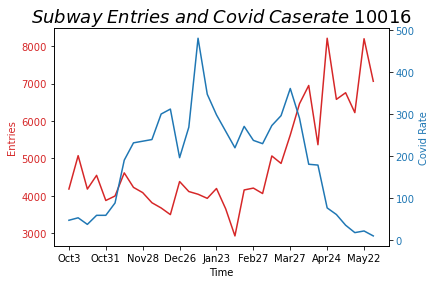

In [269]:
#PLOTTING
#Covid and ridership over time

#PROCEDURE FOR 10016
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Entries', color=color)
ax1.plot(merged_10016_cleaned.index.values, merged_10016_cleaned['ENTRIES'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Covid Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_10016_cleaned.index.values, merged_10016_cleaned['COVID'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('$Subway\; Entries\; and\; Covid\; Caserate \; 10016$', fontsize=18)
plt.xticks(['201003', '201031', '201128', '201226', '210123', '210227','210327', '210424', '210522'], ['Oct3', 'Oct31', 'Nov28', 'Dec26', 'Jan23',
                                                                                                       'Feb27', 'Mar27', 'Apr24', 'May22'])
plt.savefig("subway_covid_time_series_10016.png")


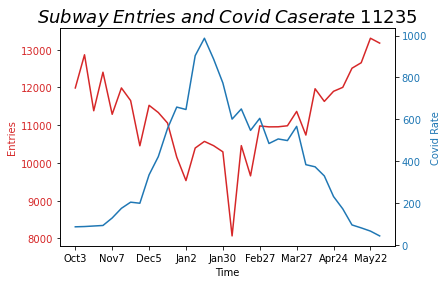

In [268]:
#SAME PROCEDURE FOR 11235
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Entries', color=color)
ax1.plot(merged_11235_cleaned.index.values, merged_11235_cleaned['ENTRIES'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Covid Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_11235_cleaned.index.values, merged_11235_cleaned['COVID'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('$Subway\; Entries\; and\; Covid\; Caserate \; 11235$', fontsize=18)
plt.xticks(['201003', '201107', '201205', '210102', '210130', '210227','210327', '210424', '210522'], ['Oct3', 'Nov7', 'Dec5', 'Jan2', 'Jan30',
                                                                                                       'Feb27', 'Mar27', 'Apr24', 'May22'])
plt.savefig("subway_covid_time_series_11235.png")

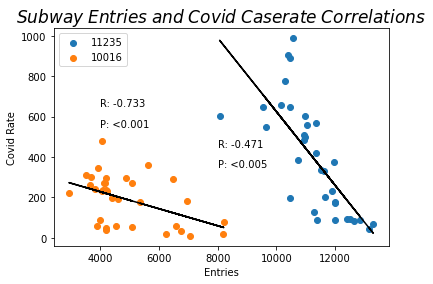

In [271]:
#Now Look at scatterplots between entries and covid and add regression line

#and scatters together as well
#Unsurprising that ridership is negatively correlated with covid

x = merged_11235_cleaned["ENTRIES"]
y = merged_11235_cleaned["COVID"]
slope1, intercept1, r_value1, p_value1, std_err1 = ss.linregress(x, y)
plt.scatter(x, y, label = "11235")
plt.plot(x, slope1*x + intercept1, color ="k")
plt.text(4000, 650, "R: -0.733")
plt.text(4000, 550, "P: <0.001");
plt.title('$Subway\; Entries\; and\; Covid\; Caserate\; Correlations$', fontsize=17)

x = merged_10016_cleaned["ENTRIES"]
y = merged_10016_cleaned["COVID"]
slope2, intercept2, r_value2, p_value2, std_err2 = ss.linregress(x, y)
plt.scatter(x, y, label = "10016")
plt.plot(x, slope2*x + intercept2, color ="k")
plt.text(8000, 450, "R: -0.471")
plt.text(8000, 350, "P: <0.005");
plt.legend(loc="upper left");
plt.xlabel('Entries')
plt.ylabel('Covid Rate');
plt.savefig("subway_covid_correlations.png")